In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Funzione per scaricare i dati storici
def download_data(exchange_name, symbol, timeframe, since, until=None):
    exchange_class = getattr(ccxt, exchange_name)
    exchange = exchange_class({'rateLimit': 1200, 'enableRateLimit': True})
    all_data = []
    since_timestamp = since
    while True:
        data = exchange.fetch_ohlcv(symbol, timeframe, since=since_timestamp, limit=1000)
        if not data:
            break
        all_data.extend(data)
        since_timestamp = data[-1][0] + 1
        if until and since_timestamp > until:
            break
    df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    if until:
        df = df[df['timestamp'] <= pd.to_datetime(until, unit='ms')]
    return df

# Parametri principali
EXCHANGE = 'bybit'  # Scegli l'exchange (ad esempio 'binance')
SYMBOL = 'BTC/USDT'  # Coppia di crypto
SINCE = int(datetime(2021, 1, 1).timestamp()) * 1000  # Data di inizio
UNTIL = int(datetime(2021, 5, 1).timestamp()) * 1000  # Data di fine (opzionale)
TIMEFRAME_GRANDE = '1d'  # Timeframe grande (ad esempio 1 giorno)
TIMEFRAME_PICCOLO = '4h'  # Timeframe piccolo (ad esempio 4 ore)

# Scarica dati con timeframe grande e piccolo
data_grande = download_data(EXCHANGE, SYMBOL, TIMEFRAME_GRANDE, SINCE, UNTIL)
data_piccolo = download_data(EXCHANGE, SYMBOL, TIMEFRAME_PICCOLO, SINCE, UNTIL)

In [3]:
data_grande

,timestamp,open,high,low,close,volume


In [5]:
data_piccolo

,timestamp,open,high,low,close,volume


In [ ]:
# Analisi dell'indecisione
indecision_data = []

for i in range(1, len(data_grande)):
    start_time = data_grande['timestamp'].iloc[i - 1]
    end_time = data_grande['timestamp'].iloc[i]
    
    # Filtra dati a timeframe piccolo corrispondenti all'intervallo del timeframe grande
    df_piccolo_period = data_piccolo[(data_piccolo['timestamp'] >= start_time) & (data_piccolo['timestamp'] < end_time)]
    
    if not df_piccolo_period.empty:
        # Controlla se il trend del timeframe grande era positivo o negativo
        trend = 'positivo' if data_grande['close'].iloc[i] > data_grande['close'].iloc[i - 1] else 'negativo'
        
        if trend == 'positivo':
            # Calcola "indecisione" come ritracciamenti negativi durante la salita
            indecisione = df_piccolo_period[df_piccolo_period['close'] < df_piccolo_period['close'].shift(1)]['close'].pct_change().abs()
        else:
            # Calcola "indecisione" come risalite durante una discesa
            indecisione = df_piccolo_period[df_piccolo_period['close'] > df_piccolo_period['close'].shift(1)]['close'].pct_change().abs()
        
        if not indecisione.empty:
            media_indecisione = indecisione.mean()
            max_indecisione = indecisione.max()
            min_indecisione = indecisione.min()
            std_indecisione = indecisione.std()
            indecision_data.append({'timeframe_grande': start_time, 'media_indecisione': media_indecisione, 'max_indecisione': max_indecisione, 'min_indecisione': min_indecisione, 'std_indecisione': std_indecisione})

# Crea DataFrame per visualizzare i dati
indecision_df = pd.DataFrame(indecision_data)

# Stampa alcune statistiche delle "indecisioni"
print(indecision_df.describe())

# Grafico della media mobile delle indecisioni
plt.figure(figsize=(12, 6))
plt.plot(indecision_df['timeframe_grande'], indecision_df['media_indecisione'], label='Indecisione Media')
plt.title('Media Mobile delle Indecisioni')
plt.xlabel('Tempo')
plt.ylabel('Indecisione (%)')
plt.legend()
plt.show()

ValueError: Cannot describe a DataFrame without columns

In [8]:
# Funzione per scaricare i dati storici
def download_data(exchange_name, symbol, timeframe, since, until=None):
    print(f"Inizializzazione dell'exchange: {exchange_name}")
    exchange_class = getattr(ccxt, exchange_name)
    exchange = exchange_class()
    exchange.load_markets()
    print(f"Exchange {exchange_name} caricato con successo.")
    all_data = []
    since_timestamp = since
    while since_timestamp < until:
        print(f"Scaricando dati dal {since_timestamp}...")
        try:
            data = exchange.fetch_ohlcv(symbol, timeframe, since=since_timestamp, limit=1000)
            if not data:
                print("Nessun dato ricevuto. Fine del ciclo.")
                break
            print(f"Scaricati {len(data)} dati.")
            all_data.extend(data)
            since_timestamp = data[-1][0] + 1
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API
        except Exception as e:
            print(f"Errore durante il download dei dati: {e}")
            break
    if not all_data:
        print("Nessun dato scaricato. Controlla i parametri di input.")
        return pd.DataFrame()  # Ritorna un DataFrame vuoto se non ci sono dati
    df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    if until:
        df = df[df['timestamp'] <= pd.to_datetime(until, unit='ms')]
    print(f"Dati scaricati con successo per {symbol}.")
    return df

# Parametri principali
EXCHANGE = 'bybit'  # Scegli l'exchange (ad esempio 'binance')
SYMBOL = 'BTC/USDT'  # Coppia di crypto
SINCE = int(datetime(2023, 1, 1).timestamp()) * 1000  # Data di inizio
UNTIL = int(datetime(2023, 5, 1).timestamp()) * 1000  # Data di fine (opzionale)
TIMEFRAME_GRANDE = '1d'  # Timeframe grande (ad esempio 1 giorno)
TIMEFRAME_PICCOLO = '4h'  # Timeframe piccolo (ad esempio 4 ore)

# Scarica dati con timeframe grande e piccolo
print("Scaricamento dei dati per timeframe grande...")
data_grande = download_data(EXCHANGE, SYMBOL, TIMEFRAME_GRANDE, SINCE, UNTIL)
print("Scaricamento dei dati per timeframe piccolo...")
data_piccolo = download_data(EXCHANGE, SYMBOL, TIMEFRAME_PICCOLO, SINCE, UNTIL)

Scaricamento dei dati per timeframe grande...
Inizializzazione dell'exchange: bybit
Exchange bybit caricato con successo.
Scaricando dati dal 1672527600000...
Scaricati 704 dati.
Dati scaricati con successo per BTC/USDT.
Scaricamento dei dati per timeframe piccolo...
Inizializzazione dell'exchange: bybit
Exchange bybit caricato con successo.
Scaricando dati dal 1672527600000...
Scaricati 999 dati.
Dati scaricati con successo per BTC/USDT.


In [9]:
exchange_class = getattr(ccxt, 'bybit')
exchange = exchange_class()
exchange.timeframes

{'1m': '1',
 '3m': '3',
 '5m': '5',
 '15m': '15',
 '30m': '30',
 '1h': '60',
 '2h': '120',
 '4h': '240',
 '6h': '360',
 '12h': '720',
 '1d': 'D',
 '1w': 'W',
 '1M': 'M'}

In [ ]:
# Controlla se i dati sono vuoti
if data_grande.empty or data_piccolo.empty:
    print("Errore: Non sono stati scaricati dati sufficienti per uno o entrambi i timeframe.")
else:
    # Analisi dell'indecisione
    indecision_data = []

    for i in range(1, len(data_grande)):
        start_time = data_grande['timestamp'].iloc[i - 1]
        end_time = data_grande['timestamp'].iloc[i]

        # Filtra dati a timeframe piccolo corrispondenti all'intervallo del timeframe grande
        df_piccolo_period = data_piccolo[(data_piccolo['timestamp'] >= start_time) & (data_piccolo['timestamp'] < end_time)]

        if not df_piccolo_period.empty:
            # Controlla se il trend del timeframe grande era positivo o negativo
            trend = 'positivo' if data_grande['close'].iloc[i] > data_grande['close'].iloc[i - 1] else 'negativo'

            if trend == 'positivo':
                # Calcola "indecisione" come ritracciamenti negativi durante la salita
                indecisione = df_piccolo_period[df_piccolo_period['close'] < df_piccolo_period['close'].shift(1)]['close'].pct_change().abs()
            else:
                # Calcola "indecisione" come risalite durante una discesa
                indecisione = df_piccolo_period[df_piccolo_period['close'] > df_piccolo_period['close'].shift(1)]['close'].pct_change().abs()

            if not indecisione.empty:
                media_indecisione = indecisione.mean() * 100
                max_indecisione = indecisione.max() * 100
                min_indecisione = indecisione.min() * 100
                std_indecisione = indecisione.std() * 100
                indecision_data.append({'timeframe_grande': start_time, 'media_indecisione': media_indecisione, 'max_indecisione': max_indecisione, 'min_indecisione': min_indecisione, 'std_indecisione': std_indecisione})

    # Crea DataFrame per visualizzare i dati
    if indecision_data:
        indecision_df = pd.DataFrame(indecision_data)

        # Stampa alcune statistiche delle "indecisioni"
        print(indecision_df.describe())

        # Grafico della media mobile delle indecisioni
        plt.figure(figsize=(12, 6))
        plt.plot(indecision_df['timeframe_grande'], indecision_df['media_indecisione'], label='Indecisione Media')
        plt.title('Media Mobile delle Indecisioni')
        plt.xlabel('Tempo')
        plt.ylabel('Indecisione (%)')
        plt.legend()
        plt.show()
    else:
        print("Non ci sono dati di indecisione da visualizzare.")

In [11]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import re

In [13]:
# Funzione per scaricare i dati storici con timeframe di 1 minuto
def download_data_minute(exchange_name, symbol, since, until=None):
    print(f"Inizializzazione dell'exchange: {exchange_name}")
    exchange_class = getattr(ccxt, exchange_name)
    exchange = exchange_class()
    exchange.load_markets()
    print(f"Exchange {exchange_name} caricato con successo.")
    all_data = []
    since_timestamp = since
    while since_timestamp < until:
        print(f"Scaricando dati dal {since_timestamp}...")
        try:
            data = exchange.fetch_ohlcv(symbol, '1m', since=since_timestamp, limit=1000)
            if not data:
                print("Nessun dato ricevuto. Fine del ciclo.")
                break
            print(f"Scaricati {len(data)} dati.")
            all_data.extend(data)
            since_timestamp = data[-1][0] + 1
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API
        except Exception as e:
            print(f"Errore durante il download dei dati: {e}")
            break
    if not all_data:
        print("Nessun dato scaricato. Controlla i parametri di input.")
        return pd.DataFrame()  # Ritorna un DataFrame vuoto se non ci sono dati
    df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    if until:
        df = df[df['timestamp'] <= pd.to_datetime(until, unit='ms')]
    print(f"Dati scaricati con successo per {symbol}.")
    return df

# Funzione per aggregare i dati

def parse_timeframe(timeframe):
    match = re.match(r"([\d\.]+)([mhdwM])", timeframe)
    if not match:
        raise ValueError(f"Timeframe non valido: {timeframe}")
    value, unit = match.groups()
    value = float(value)
    if unit == 'm':
        return timedelta(minutes=value)
    elif unit == 'h':
        return timedelta(hours=value)
    elif unit == 'd':
        return timedelta(days=value)
    elif unit == 'w':
        return timedelta(weeks=value)
    elif unit == 'M':
        return timedelta(days=value * 30)  # Approssimazione per un mese
    else:
        raise ValueError(f"Unità di tempo non riconosciuta: {unit}")

# Aggrega i dati al timeframe richiesto
def aggregate_data(df, timeframe):
    agg_interval = parse_timeframe(timeframe)
    df = df.set_index('timestamp')
    resampled = df.resample(agg_interval).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()
    return resampled.reset_index()

# Parametri principali
EXCHANGE = 'bybit'  # Scegli l'exchange (ad esempio 'binance')
SYMBOL = 'BTC/USDT'  # Coppia di crypto
SINCE = int(datetime(2023, 1, 1).timestamp()) * 1000  # Data di inizio
UNTIL = int(datetime(2023, 5, 1).timestamp()) * 1000  # Data di fine (opzionale)
TIMEFRAME_GRANDE = '1d'  # Timeframe grande (ad esempio 1 giorno)
TIMEFRAME_PICCOLO = '4h'  # Timeframe piccolo (ad esempio 4 ore)

# Scarica dati con timeframe di 1 minuto
print("Scaricamento dei dati con timeframe di 1 minuto...")
data_minute = download_data_minute(EXCHANGE, SYMBOL, SINCE, UNTIL)

Scaricamento dei dati con timeframe di 1 minuto...
Inizializzazione dell'exchange: bybit
Exchange bybit caricato con successo.
Scaricando dati dal 1672527600000...
Scaricati 1000 dati.
Scaricando dati dal 1672587540001...
Scaricati 999 dati.
Scaricando dati dal 1672647480001...
Scaricati 999 dati.
Scaricando dati dal 1672707420001...
Scaricati 999 dati.
Scaricando dati dal 1672767360001...
Scaricati 999 dati.
Scaricando dati dal 1672827300001...
Scaricati 999 dati.
Scaricando dati dal 1672887240001...
Scaricati 999 dati.
Scaricando dati dal 1672947180001...
Scaricati 999 dati.
Scaricando dati dal 1673007120001...
Scaricati 999 dati.
Scaricando dati dal 1673067060001...
Scaricati 999 dati.
Scaricando dati dal 1673127000001...
Scaricati 999 dati.
Scaricando dati dal 1673186940001...
Scaricati 999 dati.
Scaricando dati dal 1673246880001...
Scaricati 999 dati.
Scaricando dati dal 1673306820001...
Scaricati 999 dati.
Scaricando dati dal 1673366760001...
Scaricati 999 dati.
Scaricando dati d

Aggregazione dei dati per timeframe grande (1d)...
Aggregazione dei dati per timeframe piccolo (4h)...
Analisi dell'indecisione per il periodo: 2022-12-31 00:00:00 - 2023-01-01 00:00:00
Trend del periodo: positivo
Analisi dell'indecisione per il periodo: 2023-01-01 00:00:00 - 2023-01-02 00:00:00
Trend del periodo: positivo
Indecisione calcolata - Media: nan%, Max: nan%, Min: nan%, Std: nan%
Analisi dell'indecisione per il periodo: 2023-01-02 00:00:00 - 2023-01-03 00:00:00
Trend del periodo: negativo
Indecisione calcolata - Media: 0.00%, Max: 0.00%, Min: 0.00%, Std: 0.00%
Analisi dell'indecisione per il periodo: 2023-01-03 00:00:00 - 2023-01-04 00:00:00
Trend del periodo: positivo
Indecisione calcolata - Media: 0.00%, Max: 0.00%, Min: 0.00%, Std: 0.00%
Analisi dell'indecisione per il periodo: 2023-01-04 00:00:00 - 2023-01-05 00:00:00
Trend del periodo: negativo
Indecisione calcolata - Media: 0.00%, Max: 0.00%, Min: 0.00%, Std: 0.00%
Analisi dell'indecisione per il periodo: 2023-01-05 00

,timeframe_grande,media_indecisione,max_indecisione,min_indecisione,std_indecisione
count,115,106.000000,106.000000,106.000000,57.000000
mean,2023-02-28 00:37:33.913043456,0.008871,0.011209,0.006912,0.004854
min,2023-01-01 00:00:00,0.000028,0.000028,0.000011,0.000187
25%,2023-01-29 12:00:00,0.002168,0.002636,0.001065,0.001269
50%,2023-02-27 00:00:00,0.005534,0.007023,0.002707,0.003175
75%,2023-03-29 12:00:00,0.010021,0.013223,0.007019,0.006335
max,2023-04-29 00:00:00,0.090186,0.090186,0.090186,0.028023
std,NaN,0.012137,0.013738,0.012125,0.005589


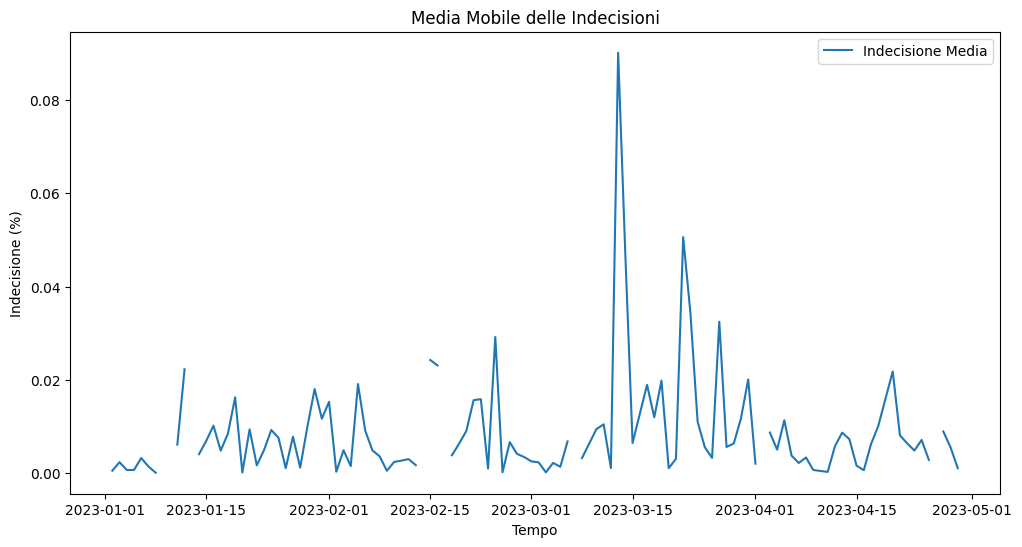

In [16]:
# Controlla se i dati sono vuoti
if data_minute.empty:
    print("Errore: Non sono stati scaricati dati sufficienti.")
else:
    # Aggrega i dati per ottenere data_grande e data_piccolo
    print(f"Aggregazione dei dati per timeframe grande ({TIMEFRAME_GRANDE})...")
    data_grande = aggregate_data(data_minute, TIMEFRAME_GRANDE)
    print(f"Aggregazione dei dati per timeframe piccolo ({TIMEFRAME_PICCOLO})...")
    data_piccolo = aggregate_data(data_minute, TIMEFRAME_PICCOLO)

    # Analisi dell'indecisione
    indecision_data = []

    for i in range(1, len(data_grande)):
        start_time = data_grande['timestamp'].iloc[i - 1]
        end_time = data_grande['timestamp'].iloc[i]
        
        print(f"Analisi dell'indecisione per il periodo: {start_time} - {end_time}")
        # Filtra dati a timeframe piccolo corrispondenti all'intervallo del timeframe grande
        df_piccolo_period = data_piccolo[(data_piccolo['timestamp'] >= start_time) & (data_piccolo['timestamp'] < end_time)]
        
        if not df_piccolo_period.empty:
            # Controlla se il trend del timeframe grande era positivo o negativo
            trend = 'positivo' if data_grande['close'].iloc[i] > data_grande['close'].iloc[i - 1] else 'negativo'
            print(f"Trend del periodo: {trend}")
            
            if trend == 'positivo':
                # Calcola "indecisione" come ritracciamenti negativi durante la salita
                indecisione = df_piccolo_period[df_piccolo_period['close'] < df_piccolo_period['close'].shift(1)]['close'].pct_change().abs()
            else:
                # Calcola "indecisione" come risalite durante una discesa
                indecisione = df_piccolo_period[df_piccolo_period['close'] > df_piccolo_period['close'].shift(1)]['close'].pct_change().abs()
            
            if not indecisione.empty:
                media_indecisione = indecisione.mean()
                max_indecisione = indecisione.max()
                min_indecisione = indecisione.min()
                std_indecisione = indecisione.std()
                print(f"Indecisione calcolata - Media: {media_indecisione:.2f}%, Max: {max_indecisione:.2f}%, Min: {min_indecisione:.2f}%, Std: {std_indecisione:.2f}%")
                indecision_data.append({'timeframe_grande': start_time, 'media_indecisione': media_indecisione, 'max_indecisione': max_indecisione, 'min_indecisione': min_indecisione, 'std_indecisione': std_indecisione})

    # Crea DataFrame per visualizzare i dati
    if indecision_data:
        indecision_df = pd.DataFrame(indecision_data)

        # Stampa alcune statistiche delle "indecisioni"
        display(indecision_df.describe())

        # Grafico della media mobile delle indecisioni
        plt.figure(figsize=(12, 6))
        plt.plot(indecision_df['timeframe_grande'], indecision_df['media_indecisione'], label='Indecisione Media')
        plt.title('Media Mobile delle Indecisioni')
        plt.xlabel('Tempo')
        plt.ylabel('Indecisione (%)')
        plt.legend()
        plt.show()
    else:   
        print("Non ci sono dati di indecisione da visualizzare.")